In [1]:
# open parquets/deployments.parquet

import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa

# Read parquet file
deploys_df = pd.read_parquet('parquets/deployments.parquet', engine='pyarrow')

deploys_df.platform.value_counts()

snapshot    20782
daohaus      3528
aragon       2387
tally        2375
realms       2165
daostack       58
Name: platform, dtype: int64

In [2]:
deploys_df.shape

(31295, 7)

In [3]:
# get the number of votes per platform but keep memory usage low
# read 'votes.parquet' in chunks
# votes_df = pd.read_parquet('parquets/votes.parquet', engine='pyarrow', columns=['weight'], limit=1000)
# votes_df.value_counts()

cols = [
    'platform',
    'platform_deployment_id',
    'voter',
    'weight'
]

import pyarrow.parquet as pq

votes_table = pq.read_table('parquets/votes.parquet', columns=cols, use_threads=True)
votes_table

pyarrow.Table
platform: string
platform_deployment_id: string
voter: string
weight: decimal256(62, 8)
----
platform: [["realms","realms","realms","realms","realms",...,"tally","tally","tally","tally","tally"],["tally","tally","tally","tally","tally",...,"tally","tally","tally","tally","tally"],...,["snapshot","snapshot","snapshot","snapshot","snapshot",...,"snapshot","snapshot","snapshot","snapshot","snapshot"],["snapshot","snapshot","snapshot","snapshot","snapshot",...,"snapshot","snapshot","snapshot","snapshot","snapshot"]]
platform_deployment_id: [["84pGFuy1Y27ApK67ApethaPvexeDWA66zNV8gm38TVeQ","84pGFuy1Y27ApK67ApethaPvexeDWA66zNV8gm38TVeQ","84pGFuy1Y27ApK67ApethaPvexeDWA66zNV8gm38TVeQ","84pGFuy1Y27ApK67ApethaPvexeDWA66zNV8gm38TVeQ","84pGFuy1Y27ApK67ApethaPvexeDWA66zNV8gm38TVeQ",...,"eip155:1:0x408ED6354d4973f66138C91495F2f2FCbd8724C3","eip155:1:0x408ED6354d4973f66138C91495F2f2FCbd8724C3","eip155:1:0x408ED6354d4973f66138C91495F2f2FCbd8724C3","eip155:1:0x408ED6354d4973f66138C91495F2f

In [4]:
votes_df = votes_table.to_pandas()

In [5]:
votes_df = votes_df[:1000000]

In [6]:
# group by platform, platform_deployment_id, voter (i.e., get the votes for each voter on each deployment) and put the weights in a list
votes_df = votes_df[cols]
votes_df = votes_df.groupby(['platform', 'platform_deployment_id', 'voter']).agg({'weight': list}).reset_index()
votes_df

,platform,platform_deployment_id,voter,weight
0,aragon,0x0017a25385931ee690dc09df6cca919d1cd007b2,0xa6dcd68a470dc5dc0021d53377d5c9f690bb8774-vot...,"[1000000000000000047.64729344, 100000000000000..."
1,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,[2333000000000000023028.40668160]
2,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,"[2333000000000000023028.40668160, 233300000000..."
3,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,"[2333000000000000023028.40668160, 233300000000..."
4,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,[131103069663104562431138.31694336]
...,...,...,...,...
489246,tally,eip155:97:0xd35Ed95E173e19CE93525De869BF60BC4A...,eip155:97:0xA1485801Ea9d4c890BC7563Ca92d90c4ae...,[101000000000000008763.74654976]
489247,tally,eip155:97:0xe849C19f7ab4c15A2F92F6EaA4144BeEd0...,eip155:97:0x3923a9BE32C52D29b81fD8facD295BCD6D...,[215619111484992523153595784578847.13811968]
489248,tally,eip155:97:0xe849C19f7ab4c15A2F92F6EaA4144BeEd0...,eip155:97:0xBF0bAc8f91490bcB4c2CfEF4A59EBd78A2...,[60172775298137451976825720112743.21788928]
489249,tally,eip155:97:0xe938cE931FEAe77624086D6f412e8e9f12...,eip155:97:0x314BfEbC283d6d79dD535D8A023705f055...,[700000000000000019548736.92127232]


In [7]:
# remove none values from the weight list
votes_df['weight'] = votes_df['weight'].apply(lambda x: [i for i in x if i is not None])
# remove empty lists
votes_df = votes_df[votes_df['weight'].map(len) > 0]

In [8]:
import numpy as np
# add a weight_min, weight_max, weight_mean, weight_median, weight_std column
# votes_df['weight_min'] = votes_df.weight.apply(lambda x: min(x))
# votes_df['weight_max'] = votes_df.weight.apply(lambda x: max(x))
# votes_df['weight_mean'] = votes_df.weight.apply(lambda x: sum(x) / len(x))
votes_df['weight_median'] = votes_df.weight.apply(lambda x: sorted(x)[len(x) // 2])
# votes_df['weight_std'] = votes_df.weight.apply(lambda x: np.std(x))
votes_df

/var/folders/yn/b6240_995k3gl4vwtnbzzy480000gq/T/ipykernel_23451/884901304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes_df['weight_median'] = votes_df.weight.apply(lambda x: sorted(x)[len(x) // 2])


,platform,platform_deployment_id,voter,weight,weight_median
0,aragon,0x0017a25385931ee690dc09df6cca919d1cd007b2,0xa6dcd68a470dc5dc0021d53377d5c9f690bb8774-vot...,"[1000000000000000047.64729344, 100000000000000...",1000000000000000047.64729344
1,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,[2333000000000000023028.40668160],2333000000000000023028.40668160
2,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,"[2333000000000000023028.40668160, 233300000000...",2333000000000000023028.40668160
3,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,"[2333000000000000023028.40668160, 233300000000...",2333000000000000023028.40668160
4,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,[131103069663104562431138.31694336],131103069663104562431138.31694336
...,...,...,...,...,...
489246,tally,eip155:97:0xd35Ed95E173e19CE93525De869BF60BC4A...,eip155:97:0xA1485801Ea9d4c890BC7563Ca92d90c4ae...,[101000000000000008763.74654976],101000000000000008763.74654976
489247,tally,eip155:97:0xe849C19f7ab4c15A2F92F6EaA4144BeEd0...,eip155:97:0x3923a9BE32C52D29b81fD8facD295BCD6D...,[215619111484992523153595784578847.13811968],215619111484992523153595784578847.13811968
489248,tally,eip155:97:0xe849C19f7ab4c15A2F92F6EaA4144BeEd0...,eip155:97:0xBF0bAc8f91490bcB4c2CfEF4A59EBd78A2...,[60172775298137451976825720112743.21788928],60172775298137451976825720112743.21788928
489249,tally,eip155:97:0xe938cE931FEAe77624086D6f412e8e9f12...,eip155:97:0x314BfEbC283d6d79dD535D8A023705f055...,[700000000000000019548736.92127232],700000000000000019548736.92127232


In [9]:
votes_df

,platform,platform_deployment_id,voter,weight,weight_median
0,aragon,0x0017a25385931ee690dc09df6cca919d1cd007b2,0xa6dcd68a470dc5dc0021d53377d5c9f690bb8774-vot...,"[1000000000000000047.64729344, 100000000000000...",1000000000000000047.64729344
1,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,[2333000000000000023028.40668160],2333000000000000023028.40668160
2,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,"[2333000000000000023028.40668160, 233300000000...",2333000000000000023028.40668160
3,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,"[2333000000000000023028.40668160, 233300000000...",2333000000000000023028.40668160
4,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,0xbdcc7647a078c05493ac72befe870556ef2d201a-vot...,[131103069663104562431138.31694336],131103069663104562431138.31694336
...,...,...,...,...,...
489246,tally,eip155:97:0xd35Ed95E173e19CE93525De869BF60BC4A...,eip155:97:0xA1485801Ea9d4c890BC7563Ca92d90c4ae...,[101000000000000008763.74654976],101000000000000008763.74654976
489247,tally,eip155:97:0xe849C19f7ab4c15A2F92F6EaA4144BeEd0...,eip155:97:0x3923a9BE32C52D29b81fD8facD295BCD6D...,[215619111484992523153595784578847.13811968],215619111484992523153595784578847.13811968
489248,tally,eip155:97:0xe849C19f7ab4c15A2F92F6EaA4144BeEd0...,eip155:97:0xBF0bAc8f91490bcB4c2CfEF4A59EBd78A2...,[60172775298137451976825720112743.21788928],60172775298137451976825720112743.21788928
489249,tally,eip155:97:0xe938cE931FEAe77624086D6f412e8e9f12...,eip155:97:0x314BfEbC283d6d79dD535D8A023705f055...,[700000000000000019548736.92127232],700000000000000019548736.92127232


In [10]:
# we want to use the median weight to calculate the gini
# group by platform, platform_deployment_id and put the median weights in a list
votes_df = votes_df.groupby(['platform', 'platform_deployment_id']).agg({'weight_median': list}).reset_index()
votes_df

,platform,platform_deployment_id,weight_median
0,aragon,0x0017a25385931ee690dc09df6cca919d1cd007b2,[1000000000000000047.64729344]
1,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,"[2333000000000000023028.40668160, 233300000000..."
2,aragon,0x00ccb72bd1f72882d89774d9acccce616ed9227d,"[29999999999999997781788.97805312, 29999999999..."
3,aragon,0x0163c547b4abd1672e213291cc62582c357868fe,"[1.00000000, 1.00000000, 1.00000000, 1.0000000..."
4,aragon,0x016f8665ac8b24a245cddb73dcf27439f1879a40,[1.00000000]
...,...,...,...
5958,tally,eip155:97:0xca881757514963d9b84f5680BC384881cD...,"[3999999999999999657326.03428864, 199999999999..."
5959,tally,eip155:97:0xd35Ed95E173e19CE93525De869BF60BC4A...,[101000000000000008763.74654976]
5960,tally,eip155:97:0xe849C19f7ab4c15A2F92F6EaA4144BeEd0...,"[215619111484992523153595784578847.13811968, 6..."
5961,tally,eip155:97:0xe938cE931FEAe77624086D6f412e8e9f12...,[700000000000000019548736.92127232]


In [13]:
from decimal import Decimal

def gini(x):
    if sum(x) == 0:
        return Decimal(0)

    x = sorted(x)
    n = len(x)
    s = sum(x)
    d = n * s
    G = sum(xi * (n - i) for i, xi in enumerate(x))
    return (d + s - 2 * G) / d

# Example usage:
income_values = [Decimal('1000'), Decimal('2000'), Decimal('3000'), Decimal('4000'), Decimal('5000')]


# calculate the gini coefficient for each deployment
votes_df['gini'] = votes_df['weight_median'].apply(lambda x: gini(x))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


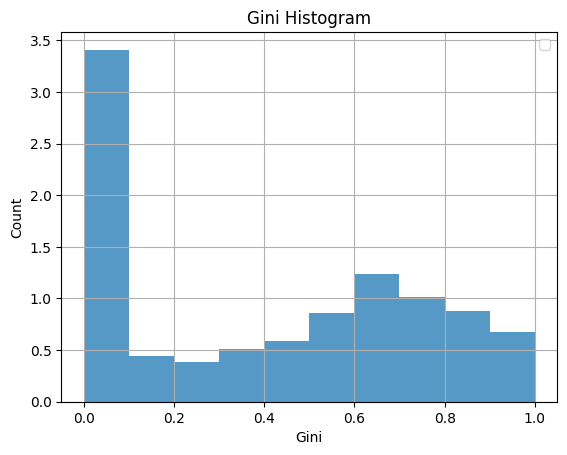

In [35]:
more_than_two_voters = votes_df[votes_df['weight_median'].map(len) > 2]


# show where the count of votes is greater than 2, stacked bars colored by the number of voters
import matplotlib.pyplot as plt
import numpy as np

# the histogram of the data
n, bins, patches = plt.hist(more_than_two_voters['gini'], 10, density=True, alpha=0.75)

plt.legend()
plt.xlabel('Gini')
plt.ylabel('Count')
plt.title('Gini Histogram')
plt.grid(True)
plt.show()

In [ ]:
# find the deployment with the most voters
top = votes_df.groupby(['platform', 'platform_deployment_id']).agg({'voter': 'count'}).reset_index().sort_values(by='voter', ascending=False).iloc[0]
platform_deployment_id = top.platform_deployment_id
platform = top.platform
print(platform_deployment_id, platform)


KeyError: "Column(s) ['voter'] do not exist"

In [ ]:
deep_dive_df = votes_df[(votes_df.platform_deployment_id == platform_deployment_id) & (votes_df.platform == platform)]
deep_dive_df.shape

(79419, 9)

In [ ]:
deep_dive_df.head(3)

,platform,platform_deployment_id,voter,weight,weight_min,weight_max,weight_mean,weight_median,weight_std
407841,tally,eip155:42161:0xf07DeD9dC292157749B6Fd268E37DF6...,eip155:42161:0x000000000A38444e0a6E37d3b630d7e...,[1555913081898240508010.87086592],1555913081898240508010.87086592,1555913081898240508010.87086592,1555913081898240508010.870866,1555913081898240508010.87086592,8E-8
407842,tally,eip155:42161:0xf07DeD9dC292157749B6Fd268E37DF6...,eip155:42161:0x000000006F457c0f8F560333d9c2877...,[0E-8],0E-8,0E-8,0E-8,0E-8,0E-8
407843,tally,eip155:42161:0xf07DeD9dC292157749B6Fd268E37DF6...,eip155:42161:0x0000001089167600c25258Da29d2e2c...,[693750003533319463.60668160],693750003533319463.60668160,693750003533319463.60668160,693750003533319463.60668160,693750003533319463.60668160,0E-8


In [ ]:
# # make a candlestick chart of the votes

# import plotly.graph_objects as go

# # use the index of the voter columns
# fig = go.Figure(data=[go.Candlestick(x=deep_dive_df.voter.index,
#                 open=deep_dive_df.weight_mean - deep_dive_df.weight_std,
#                 high=deep_dive_df.weight_max,
#                 low=deep_dive_df.weight_min,
#                 close=deep_dive_df.weight_mean + deep_dive_df.weight_std)])
# # make y axis logarithmic
# fig.update_layout(yaxis_type="log")
# fig.show()

In [ ]:
# # bar chart of the median values
# # clear fig
# fig = go.Figure()
# # order the voters by the median value
# deep_dive_df = deep_dive_df.sort_values(by='weight_median', ascending=True)
# # black lines of the median values
# fig = go.Figure(data=[go.Bar(x=deep_dive_df.voter, y=deep_dive_df.weight_median, marker_color='black', name='median', opacity=0.5)])
# fig.add_trace(go.Scatter(x=deep_dive_df.voter, y=deep_dive_df.weight_max, mode='markers', name='median', marker_color='black'))
# fig.update_layout(yaxis_type="log")
# # add a dot for the max values
# fig.add_trace(go.Scatter(x=deep_dive_df.voter, y=deep_dive_df.weight_max, mode='markers', name='max'))
# # same for mins
# fig.add_trace(go.Scatter(x=deep_dive_df.voter, y=deep_dive_df.weight_min, mode='markers', name='min'))
# # hide the x axis
# fig.update_layout(xaxis_showticklabels=False)
# fig.show()

In [ ]:
# how many unique deep_dive_df.voter are there?
len(deep_dive_df.voter.unique())

59